In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxopt
import random
from sklearn.metrics import precision_score, recall_score, f1_score

In [228]:
def read_csv_to_dataframe(file_path):
    dataframe = pd.read_csv(file_path)
    return dataframe

In [229]:
# Code for plotting the data.
def plot_data(df, x_column, y_column, color_column):
    dataframe = df.copy(deep=False)
    dataframe['Model'] = dataframe['Model'].replace('Series N', 'red').replace('Series M', 'blue').replace('Series L', 'green')
    plt.scatter(dataframe[x_column], dataframe[y_column], c=dataframe[color_column])
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"Scatter plot of {y_column} vs {x_column}")
    plt.show()

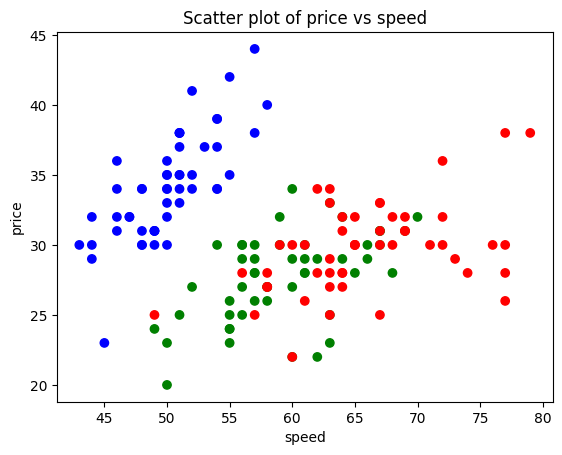

     Unnamed: 0  speed  price    hp  mileage     Model
0             0   51.0   35.0  14.0      2.0  Series M
1             1   49.0   30.0  14.0      2.0  Series M
2             2   47.0   32.0  13.0      2.0  Series M
3             3   46.0   31.0  15.0      2.0  Series M
4             4   50.0   36.0  14.0      2.0  Series M
..          ...    ...    ...   ...      ...       ...
145         145   67.0   30.0  52.0     23.0  Series N
146         146   63.0   25.0  50.0     19.0  Series N
147         147   65.0   30.0  52.0     20.0  Series N
148         148   62.0   34.0  54.0     23.0  Series N
149         149   59.0   30.0  51.0     18.0  Series N

[150 rows x 6 columns]


In [230]:
file_path = 'dataset_1.csv' 
df = read_csv_to_dataframe(file_path)
plot_data(df, 'speed', 'price', 'Model')

In [231]:
random.seed(1065)

In [232]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- Part 1 -----------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [233]:
# ----------------------------------------------------------------------------------------------------------------------
# ------------------------------------------1. Implement a OVR SVM classifier. -----------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [234]:
# Function to get the SVM weight vector and intercept having linear kernal
def get_svm_weight_vector_and_intercept_having_linear_kernal(X, y, c):
    row, col = X.shape
    K = np.zeros((row, row))
    for i in range(row):
        for j in range(row):
            K[i,j] = np.dot(X[i], X[j])

    # Constructing optimization problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(row))
    A = cvxopt.matrix(y, (1, row))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(row) * -1)
    tmp2 = np.identity(row)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(row)
    tmp2 = np.ones(row) * c
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False})

    # Langrange dual
    a = np.ravel(solution['x'])

    sv = a > 1e-5
    sv_indices = np.arange(len(a))[sv]
    sv_a = a[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    weight_vector = np.zeros(col)
    for i in range(len(sv_a)):
        weight_vector += sv_a[i] * sv_y[i] * sv_X[i]

    intercept = 0
    for n in range(len(sv_a)):
        intercept += sv_y[n]
        intercept -= np.sum(sv_a * sv_y * K[sv_indices[n], sv])
    intercept /= len(sv_a)

    return weight_vector, intercept, len(sv_X)

In [235]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------- Finding the optimal penalty (or regularization) parameter --------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [236]:
# Prediction function of SVM having linear kernal.
def condition_function_having_linear_kernal(x, y):
    value_1 = (weight_vector_m[0] * x + weight_vector_m[1] * y + intercept_m)
    value_2 = (weight_vector_n[0] * x + weight_vector_n[1] * y + intercept_n) 
    value_3 = (weight_vector_l[0] * x + weight_vector_l[1] * y + intercept_l) 
    if value_1 >= value_2 and value_1 >= value_3:
        return 0
    if value_2 >= value_1 and value_2 >= value_3:
        return 1
    if value_3 >= value_2 and value_3 >= value_1:
        return 2

In [237]:
def accuracy_score(y_true, y_pred):
    correct_count = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_count += 1
    accuracy = correct_count / len(y_true)
    return accuracy

In [268]:
def get_average_accuracy_score(c_list):
    X = np.array(df[['speed', 'price']].values.tolist())
    y = np.array(df['Model'].replace('Series M', '0').replace('Series N', '1').replace('Series L', '2').values.tolist(), dtype=np.float64)
    y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
    y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
    y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64)
    
    average_accuracy_scores = []
    for c in c_list:
        
        for _ in range(5):
            
            num_folds = 4
            fold_size = len(df) // num_folds
            indices = np.random.permutation(len(df))
        
            accuracy_scores = []
            
            # for i in range(num_folds):
            start_idx = 0
            end_idx = fold_size
            
            test_idx = indices[start_idx:end_idx]
            train_idx = np.concatenate([indices[:start_idx], indices[end_idx:]])
    
            X_train = np.array([X[j] for j in train_idx])
            X_test = np.array([X[j] for j in test_idx])
            y_train_m = np.array([y_m[j] for j in train_idx])
            y_train_n = np.array([y_n[j] for j in train_idx])
            y_train_l = np.array([y_l[j] for j in train_idx])
            y_test = np.array([y[j] for j in test_idx])
    
            weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X_train, y_train_m, c)
            weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X_train, y_train_n, c)
            weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X_train, y_train_l, c)

            y_pred_i = []
            for idx in range(len(X_test)):
                y_pred_i.append(condition_function_having_linear_kernal(X_test[idx][0], X_test[idx][1]))
    
            accuracy_scores.append(accuracy_score(y_test, y_pred_i))
        average_accuracy_scores.append(sum(accuracy_scores) / len(accuracy_scores))
        
    return average_accuracy_scores

In [276]:
def plot_c_vs_avg_accuracy_score(c_list, average_accuracy_scores):
    plt.plot(c_list, average_accuracy_scores, marker='o', linestyle='-', color='blue')
    plt.xticks(c_list, rotation=60) 
    plt.xlabel('C values')
    plt.ylabel('Accuracy Score')
    plt.title('Average Accuracy Score for Different C values')
    plt.grid()
    plt.show()

In [277]:
c_list = [0.000025, 0.00005, 0.000075, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
average_accuracy_scores = get_average_accuracy_score(c_list)

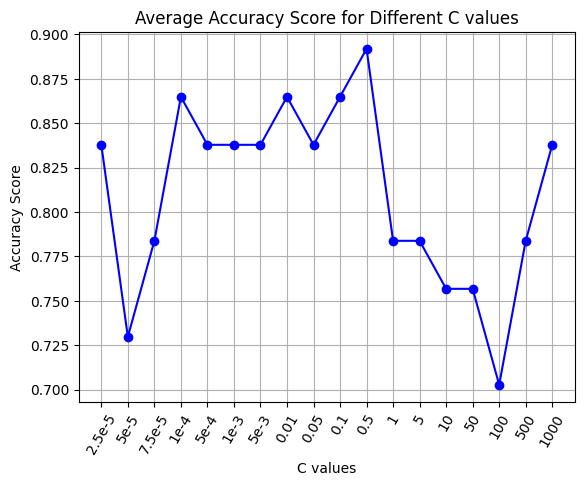

[0.8378378378378378, 0.7297297297297297, 0.7837837837837838, 0.8648648648648649, 0.8378378378378378, 0.8378378378378378, 0.8378378378378378, 0.8648648648648649, 0.8378378378378378, 0.8648648648648649, 0.8918918918918919, 0.7837837837837838, 0.7837837837837838, 0.7567567567567568, 0.7567567567567568, 0.7027027027027027, 0.7837837837837838, 0.8378378378378378]


In [279]:
c_values = ['2.5e-5', '5e-5', '7.5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '0.01', '0.05', '0.1', '0.5', '1', '5', '10', '50', '100', '500', '1000']
plot_c_vs_avg_accuracy_score(c_values, average_accuracy_scores)

In [280]:
c_list = np.arange(0.1, 1.05, 0.05)
average_accuracy_scores = get_average_accuracy_score(c_list)

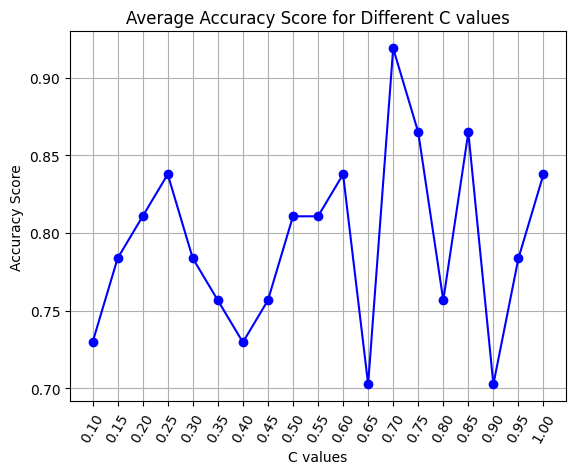

In [281]:
plot_c_vs_avg_accuracy_score(c_list, average_accuracy_scores)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------
# ------ plot the number of violated points (misclassified points) and number of support vectors on Y axis against different values C on X-axis.------
# ----------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64)

c_list = []
error_list = []
support_vector_list = []
for c in np.arange(0.001, 0.2, 0.001):
    c = round(c, 4)
    c_list.append(c)
    
    weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_m, c)
    weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_n, c)
    weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_l, c)
    
    error = 0
    for i in range(len(X)):
        value = condition_function_having_linear_kernal(X[i][0], X[i][1])
        if value == 0 and i >= 50:
           error += 1
        if value == 1 and i < 100:
           error += 1
        if value == 2 and (i < 50 or i >= 100):
           error += 1
    error_list.append(error)
    support_vector_list.append(support_vectors)

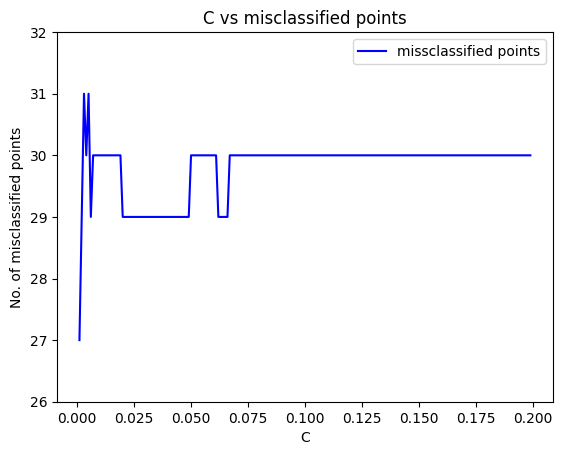

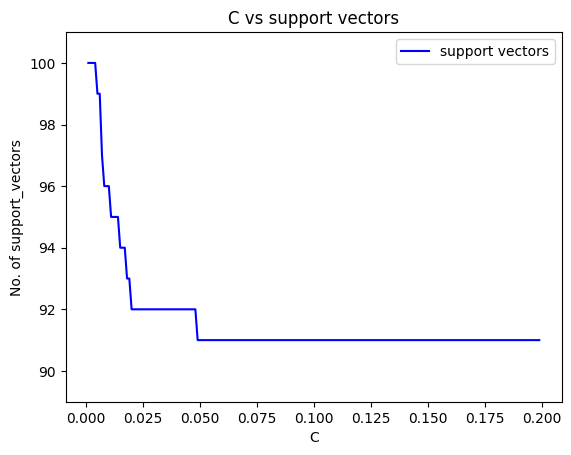

In [24]:
plt.plot(c_list, error_list, color = 'blue', label = 'missclassified points')
plt.xlabel('C')
plt.ylabel('No. of misclassified points')
plt.title('C vs misclassified points')
plt.legend()
plt.ylim(26, 32)
plt.show()

plt.plot(c_list, support_vector_list, color = 'blue', label = 'support vectors')
plt.xlabel('C')
plt.ylabel('No. of support_vectors')
plt.title('C vs support vectors')
plt.legend()
plt.ylim(89, 101)
plt.show()

In [153]:
# --------------------------------------------------------------------------------------------------------------------
# ------------------------------------------- Plotting the optimal classifier ----------------------------------------
# --------------------------------------------------------------------------------------------------------------------

In [282]:
# Finding the equation of hyperplane.
X = np.array(df[['speed', 'price']].values.tolist())
C = 0.7

y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 
weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_m, C)
weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_n, C)
weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept_having_linear_kernal(X, y_l, C)

In [283]:
y_pred_l = []
for idx in range(len(X)):
    y_pred_l.append(condition_function_having_linear_kernal(X[idx][0], X[idx][1]))

In [284]:
# Plotting the hyperplanes obtained from SVM having linear kernal.
def plot_svm_hyperplanes_having_linear_kernal(df, line_x, line_y_m, line_y_n, line_y_l):
    dataframe = df
    x_column = 'speed'
    y_column = 'price'
    x_values = dataframe[x_column].values.tolist()
    line_x = np.linspace(min(x_values), max(x_values), 100)

    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.plot(line_x, line_y_m, color='purple', label='M vs non-M')
    plt.plot(line_x, line_y_n, color='yellow', label='N vs non-N')
    plt.plot(line_x, line_y_l, color='black', label='L vs non-L')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xlim(40, 80)
    plt.ylim(15, 50)
    plt.title(f"Scatter plot of {y_column} vs {x_column}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

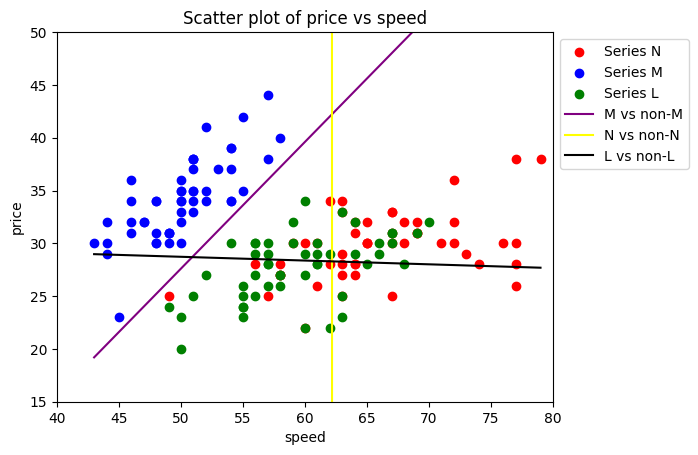

In [285]:
x_column = 'speed'
y_column = 'price'
dataframe = df.copy(deep=False)
x_values = df[x_column].values.tolist()
line_x = np.linspace(min(x_values), max(x_values), 100)
line_y_m = - (weight_vector_m[0] * line_x + intercept_m) / weight_vector_m[1]
line_y_n = - (weight_vector_n[0] * line_x + intercept_n) / weight_vector_n[1]
line_y_l = - (weight_vector_l[0] * line_x + intercept_l) / weight_vector_l[1]
plot_svm_hyperplanes_having_linear_kernal(df, line_x, line_y_m, line_y_n, line_y_l)

In [286]:
# Plotting desicion boundary of SVM having linear kernal.
def plot_svm_decision_boundary_having_linear_kernal():
    x_min, x_max = 40, 80
    y_min, y_max = 15, 50
    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    condition_values = np.vectorize(condition_function_having_linear_kernal)(xx, yy)
    plt.contourf(xx, yy, condition_values, levels=[-0.5, 0.5, 1.5, 2.5], colors=('blue', 'red', 'green'),  alpha=0.3)
    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.xlabel('Speed')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Coloring the X-Y Plane based on SVM decision boundary (Linear)')
    plt.show()

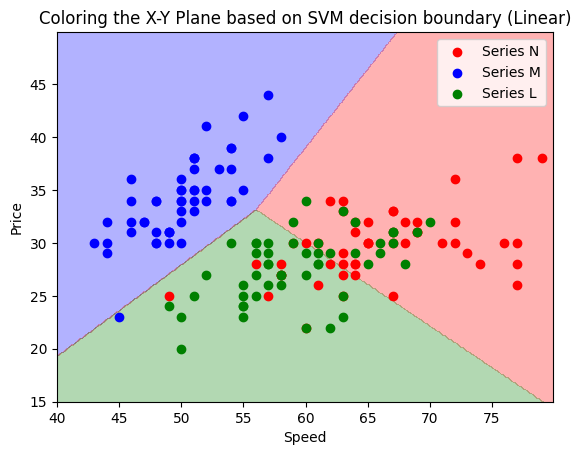

In [287]:
plot_svm_decision_boundary_having_linear_kernal()

In [159]:
# ----------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- Part 2 -----------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [160]:
# Code for polynomial kernal

In [300]:
def polynomial_kernel(X, Y, degree=3):
    return (1 + np.dot(X, Y.T)) ** degree

In [301]:
def get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y, C, degree):
    row, col = X.shape
    K = polynomial_kernel(X, X, degree)

    # Constructing optimization problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(row))
    A = cvxopt.matrix(y, (1, row))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(row) * -1)
    tmp2 = np.identity(row)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(row)
    tmp2 = np.ones(row) * C
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False})

    # Langrange dual
    a = np.ravel(solution['x'])
    sv = a > 1e-11
    sv_indices = np.arange(len(a))[sv]
    sv_a = a[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    intercept = 0
    for n in range(len(sv_a)):
        intercept += sv_y[n]
        intercept -= np.sum(sv_a * sv_y * K[sv_indices[n], sv])
    intercept /= len(sv_a)

    return sv_a, sv_X, sv_y, intercept

In [302]:
def predict_svm_with_polynomial_kernel(x, sv_alpha, sv_X, sv_y, intercept, degree=3):
    kernel_matrix = polynomial_kernel(x, sv_X, degree)
    val = np.dot(kernel_matrix, sv_alpha * sv_y) + intercept
    return val

In [303]:
def condition_function(x, y):
    value_1 = predict_svm_with_polynomial_kernel(np.array([x,y]), sv_a_m, sv_X_m, sv_y_m, intercept_m)
    value_2 = predict_svm_with_polynomial_kernel(np.array([x,y]), sv_a_n, sv_X_n, sv_y_n, intercept_n)
    value_3 = predict_svm_with_polynomial_kernel(np.array([x,y]), sv_a_l, sv_X_l, sv_y_l, intercept_l)
    if value_1 >= value_2 and value_1 >= value_3:
        return 0
    if value_2 >= value_1 and value_2 >= value_3:
        return 1
    if value_3 >= value_2 and value_3 >= value_1:
        return 2

In [312]:
# Finding the equation of hyperplane.
degree = 3
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 

c_list = []
error_list = []

for c in np.arange(0.01, 1, 0.05):
    c = round(c, 4)
    c_list.append(c)
    sv_a_m, sv_X_m, sv_y_m, intercept_m = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_m, c, degree)
    sv_a_n, sv_X_n, sv_y_n, intercept_n = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_n, c, degree)
    sv_a_l, sv_X_l, sv_y_l, intercept_l = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_l, c, degree)
    error = 0
    for i in range(len(X)):
        value = condition_function(X[i][0], X[i][1])
        if value == 0 and i >= 50:
            error += 1
        if value == 1 and i < 100:
            error += 1
        if value == 2 and (i < 50 or i >= 100):
            error += 1
    error_list.append(error)

[71, 58, 39, 28, 46, 38, 48, 37, 48, 41, 32, 36, 37, 35, 67, 37, 42, 33, 36, 51]


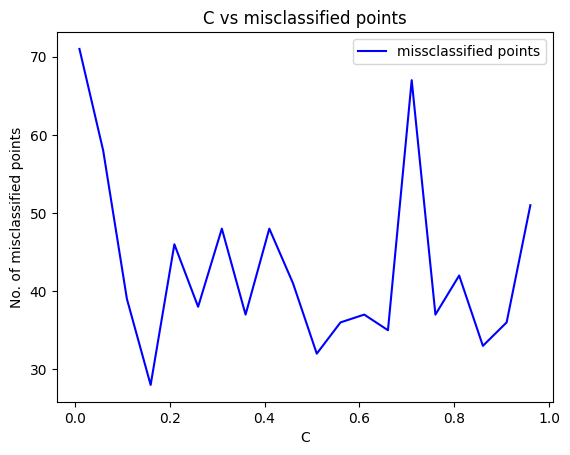

In [313]:
plt.plot(c_list, error_list, color = 'blue', label = 'missclassified points')
plt.xlabel('C')
print(error_list)
plt.ylabel('No. of misclassified points')
plt.title('C vs misclassified points')
plt.legend()
plt.show()

In [314]:
# Finding the equation of hyperplane.
degree = 3
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 

c_list = []
error_list = []

for c in np.arange(1, 100, 5):
    c = round(c, 4)
    c_list.append(c)
    sv_a_m, sv_X_m, sv_y_m, intercept_m = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_m, c, degree)
    sv_a_n, sv_X_n, sv_y_n, intercept_n = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_n, c, degree)
    sv_a_l, sv_X_l, sv_y_l, intercept_l = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_l, c, degree)
    error = 0
    for i in range(len(X)):
        value = condition_function(X[i][0], X[i][1])
        if value == 0 and i >= 50:
            error += 1
        if value == 1 and i < 100:
            error += 1
        if value == 2 and (i < 50 or i >= 100):
            error += 1
    error_list.append(error)

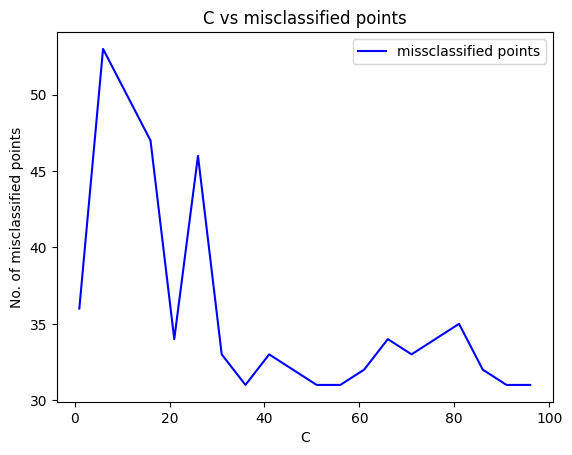

In [315]:
plt.plot(c_list, error_list, color = 'blue', label = 'missclassified points')
plt.xlabel('C')
plt.ylabel('No. of misclassified points')
plt.title('C vs misclassified points')
plt.legend()
plt.show()

In [169]:
# Plotting desicion boundary of SVM.
def plot_svm_decision_boundary():
    x_min, x_max = 40, 80
    y_min, y_max = 15, 50
    step = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    condition_values = np.vectorize(condition_function)(xx, yy)
    plt.contourf(xx, yy, condition_values, levels=[-0.5, 0.5, 1.5, 2.5], colors=('blue', 'red', 'green'),  alpha=0.3)
    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.xlabel('Speed')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Coloring the X-Y Plane based on SVM decision boundary')
    plt.show()

In [316]:
# Optimal penalty parameter of polynomial kernal.
degree = 3
C = 0.16
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 

sv_a_m, sv_X_m, sv_y_m, intercept_m = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_m, C, degree)
sv_a_n, sv_X_n, sv_y_n, intercept_n = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_n, C, degree)
sv_a_l, sv_X_l, sv_y_l, intercept_l = get_svm_weight_vector_and_intercept_having_polynomial_kernal(X, y_l, C, degree)

In [317]:
y_pred_p = []
for idx in range(len(X)):
    y_pred_p.append(condition_function(X[idx][0], X[idx][1]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2]


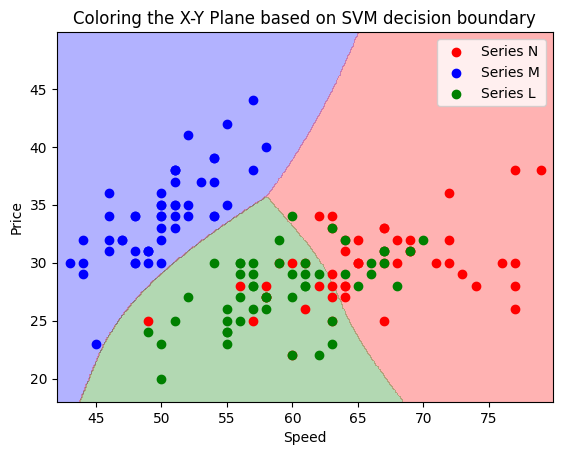

In [318]:
plot_svm_decision_boundary()

In [173]:
# ---------------------------------------------- RBF Kernal -----------------------------------------------
# ---------------------------------------------------------------------------------------------------------

In [174]:
def rbf_kernel(X, Y, gamma=0.1):
    norm = np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * norm)

In [175]:
def get_svm_weight_vector_and_intercept_having_rbf_kernal(X, y, C, gamma):
    row, col = X.shape
    K = rbf_kernel(X, X, gamma)

    # Constructing optimization problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(row))
    A = cvxopt.matrix(y, (1, row))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(row) * -1)
    tmp2 = np.identity(row)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(row)
    tmp2 = np.ones(row) * C
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False})

    # Langrange dual
    a = np.ravel(solution['x'])
    sv = a > 1e-5
    sv_indices = np.arange(len(a))[sv]
    sv_a = a[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    intercept = 0
    for n in range(len(sv_a)):
        intercept += sv_y[n]
        intercept -= np.sum(sv_a * sv_y * K[sv_indices[n], sv])
    intercept /= len(sv_a)

    return sv_a, sv_X, sv_y, intercept

In [176]:
def predict_svm_with_rbf_kernel(x, sv_alpha, sv_X, sv_y, intercept):
    kernel_matrix = rbf_kernel(x, sv_X, gamma)
    val = np.dot(kernel_matrix, sv_alpha * sv_y) + intercept
    return val

In [177]:
def condition_function(x, y):
    value_1 = predict_svm_with_rbf_kernel(np.array([[x,y]]), sv_a_m, sv_X_m, sv_y_m, intercept_m)
    value_2 = predict_svm_with_rbf_kernel(np.array([[x,y]]), sv_a_n, sv_X_n, sv_y_n, intercept_n)
    value_3 = predict_svm_with_rbf_kernel(np.array([[x,y]]), sv_a_l, sv_X_l, sv_y_l, intercept_l)
    if value_1 >= value_2 and value_1 >= value_3:
        return 0
    if value_2 >= value_1 and value_2 >= value_3:
        return 1
    if value_3 >= value_2 and value_3 >= value_1:
        return 2

In [178]:
# Plotting desicion boundary of SVM.
def plot_svm_decision_boundary():
    x_min, x_max = 42, 80
    y_min, y_max = 18, 50
    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    condition_values = np.vectorize(condition_function)(xx, yy)
    plt.contourf(xx, yy, condition_values, levels=[-0.5, 0.5, 1.5, 2.5], colors=('blue', 'red', 'green'),  alpha=0.3)
    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.xlabel('Speed')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Coloring the X-Y Plane based on SVM decision boundary')
    plt.show()

In [179]:
# Optimal penalty parameter of polynomial kernal.
gamma = 0.01
C = 0.8

X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 

sv_a_m, sv_X_m, sv_y_m, intercept_m = get_svm_weight_vector_and_intercept_having_rbf_kernal(X, y_m, C, gamma)
sv_a_n, sv_X_n, sv_y_n, intercept_n = get_svm_weight_vector_and_intercept_having_rbf_kernal(X, y_n, C, gamma)
sv_a_l, sv_X_l, sv_y_l, intercept_l = get_svm_weight_vector_and_intercept_having_rbf_kernal(X, y_l, C, gamma)

In [180]:
y_pred_rbf = []
for idx in range(len(X)):
    y_pred_rbf.append(condition_function(X[idx][0], X[idx][1]))

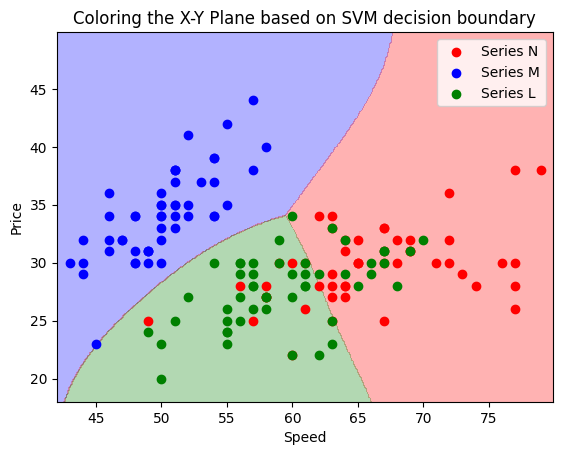

In [181]:
x_column = 'speed'
y_column = 'price'
dataframe = df.copy(deep=False)
plot_svm_decision_boundary()

In [182]:
# --------------------------------------------------------------------------------------------------------------------
# ------------------3. Evaluating classifier performance using precision, recall and f1-score. -----------------------
# --------------------------------------------------------------------------------------------------------------------

In [281]:
def plot_evalution_metrices(classifier, evalution_metric, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.bar(classifier, evalution_metric, color='green', width=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0.4, 1)
    plt.title(title)
    plt.show()

In [282]:
y_true = np.array(df['Model'].replace('Series M', '0').replace('Series N', '1').replace('Series L', '2').values.tolist(), dtype=np.float64)

In [283]:
classifier = ['Linear', 'Polynomial Kernal', 'RBF Kernal']
Class = ['Series M', 'Series L', 'Series N']
precision_per_class_l = precision_score(y_true, y_pred_l, average=None)
macro_precision_l = precision_score(y_true, y_pred_l, average='macro')
micro_precision_l = precision_score(y_true, y_pred_l, average='micro')

precision_per_class_p = precision_score(y_true, y_pred_p, average=None)
macro_precision_p = precision_score(y_true, y_pred_p, average='macro')
micro_precision_p = precision_score(y_true, y_pred_p, average='micro')

precision_per_class_rbf = precision_score(y_true, y_pred_rbf, average=None)
macro_precision_rbf = precision_score(y_true, y_pred_rbf, average='macro')
micro_precision_rbf = precision_score(y_true, y_pred_rbf, average='micro')

macro_precision = [macro_precision_l, macro_precision_p, macro_precision_rbf]
micro_precision = [micro_precision_l, micro_precision_p, micro_precision_rbf]

In [284]:
print("Precision per Class of Linear kernal:", precision_per_class_l)
print("Precision per Class of Poly. kernal: ", precision_per_class_p)
print("Precision per Class of RBF kernal: ", precision_per_class_rbf)
print("Macro Precision of Classifier: ", macro_precision)
print("Micro Precision of Classifer: ", micro_precision)

Precision per Class of Linear kernal: [1.         0.69811321 0.70833333]
Precision per Class of Poly. kernal:  [1.         0.62666667 0.73333333]
Precision per Class of RBF kernal:  [1.         0.7254902  0.73469388]
Macro Precision of Classifier:  [0.8021488469601677, 0.7866666666666666, 0.8200613578764839]
Micro Precision of Classifer:  [0.8, 0.76, 0.82]


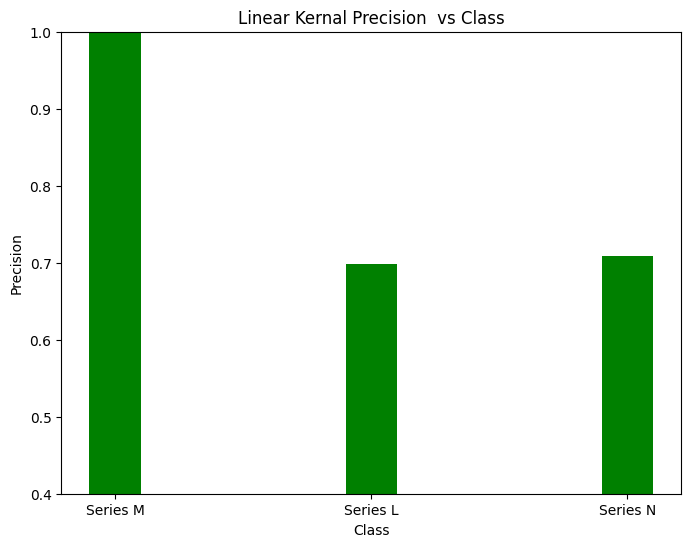

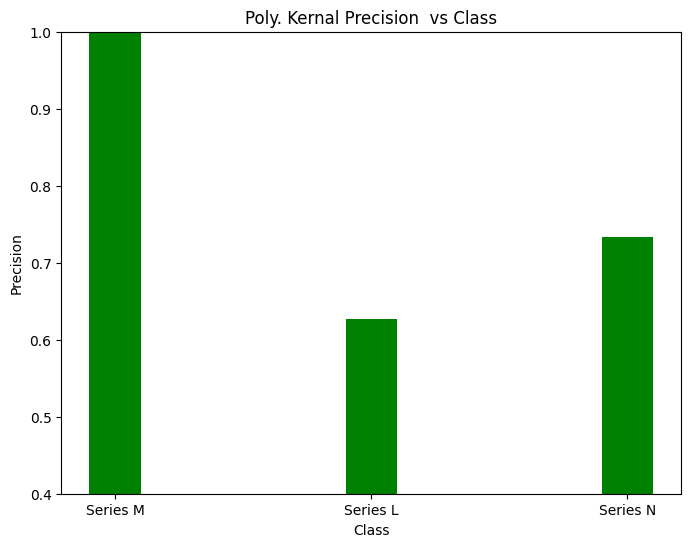

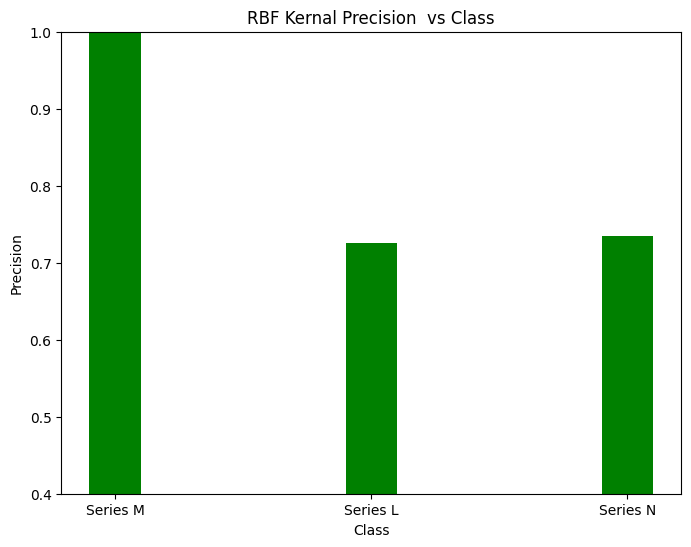

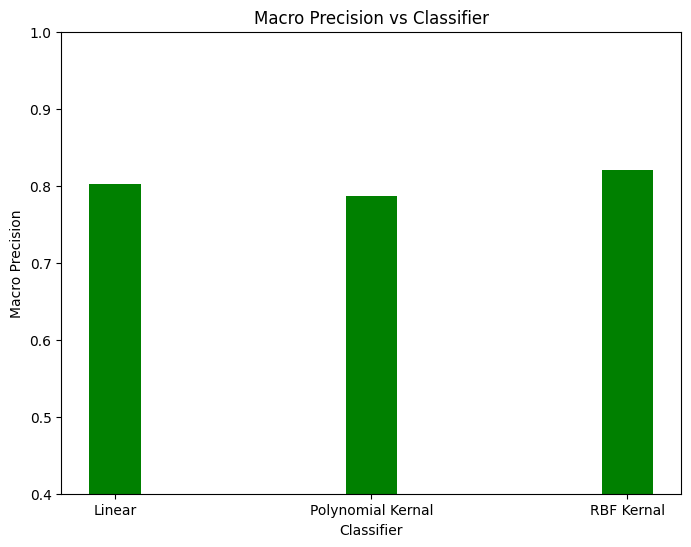

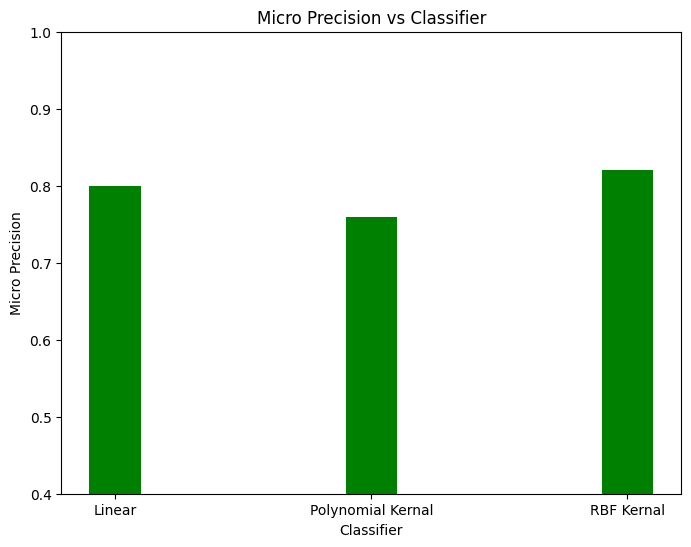

In [285]:
plot_evalution_metrices(Class, precision_per_class_l, 'Linear Kernal Precision  vs Class', 'Class', 'Precision')
plot_evalution_metrices(Class, precision_per_class_p, 'Poly. Kernal Precision  vs Class', 'Class', 'Precision')
plot_evalution_metrices(Class, precision_per_class_rbf, 'RBF Kernal Precision  vs Class', 'Class', 'Precision')
plot_evalution_metrices(classifier, macro_precision, 'Macro Precision vs Classifier', 'Classifier','Macro Precision')
plot_evalution_metrices(classifier, micro_precision, 'Micro Precision vs Classifier', 'Classifier', 'Micro Precision')

In [286]:
classifier = ['Linear', 'Polynomial Kernal', 'RBF Kernal']
Class = ['Series M', 'Series L', 'Series N']
recall_per_class_l = recall_score(y_true, y_pred_l, average=None)
macro_recall_l = recall_score(y_true, y_pred_l, average='macro')
micro_recall_l = recall_score(y_true, y_pred_l, average='micro')

recall_per_class_p = recall_score(y_true, y_pred_p, average=None)
macro_recall_p = recall_score(y_true, y_pred_p, average='macro')
micro_recall_p = recall_score(y_true, y_pred_p, average='micro')

recall_per_class_rbf = recall_score(y_true, y_pred_rbf, average=None)
macro_recall_rbf = recall_score(y_true, y_pred_rbf, average='macro')
micro_recall_rbf = recall_score(y_true, y_pred_rbf, average='micro')

macro_recall = [macro_recall_l, macro_recall_p, macro_recall_rbf]
micro_recall = [micro_recall_l, micro_recall_p, micro_recall_rbf]

In [287]:
print("Recall per Class of Linear Kernal:", recall_per_class_l)
print("Recall per Class of Poly. Kernal: ", recall_per_class_p)
print("Recall per Class of RBF Kernal: ", recall_per_class_rbf)
print("Macro Recall of Classifier: ", macro_recall)
print("Micro Recall of Classifer: ", micro_recall)

Recall per Class of Linear Kernal: [0.98 0.74 0.68]
Recall per Class of Poly. Kernal:  [0.9  0.94 0.44]
Recall per Class of RBF Kernal:  [1.   0.74 0.72]
Macro Recall of Classifier:  [0.7999999999999999, 0.7599999999999999, 0.82]
Micro Recall of Classifer:  [0.8, 0.76, 0.82]


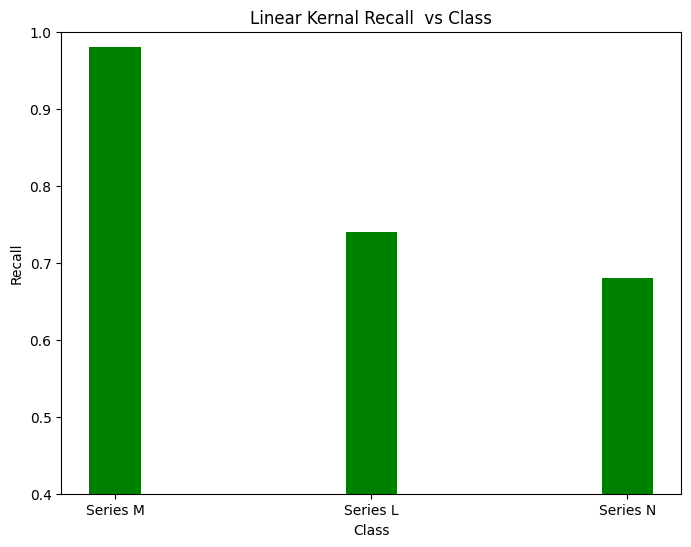

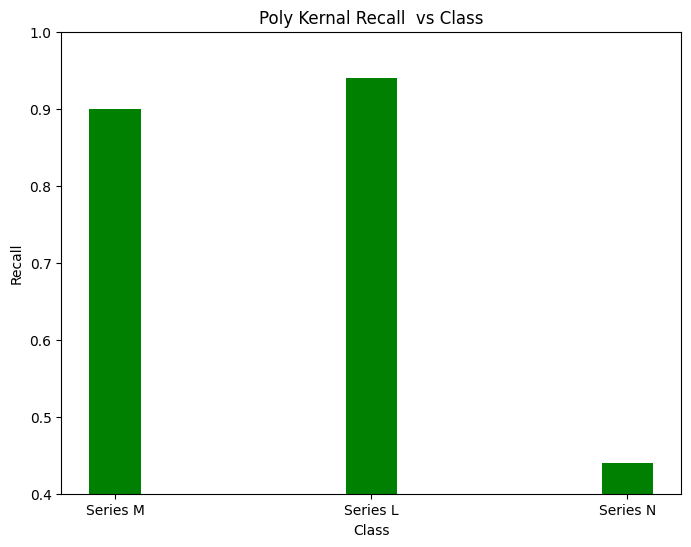

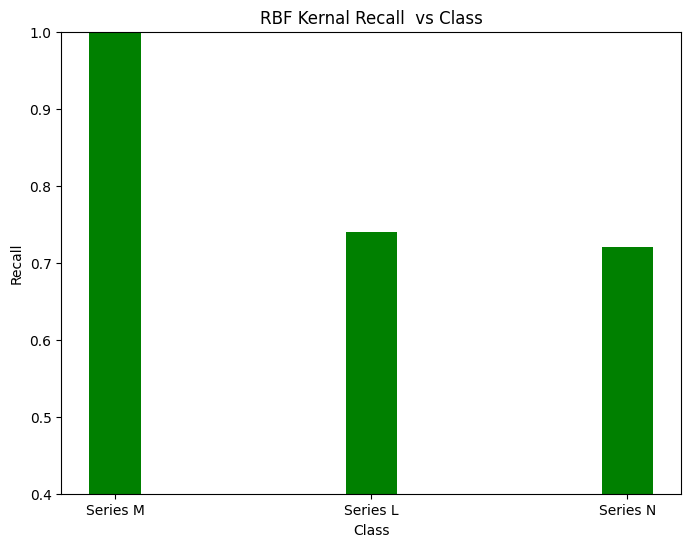

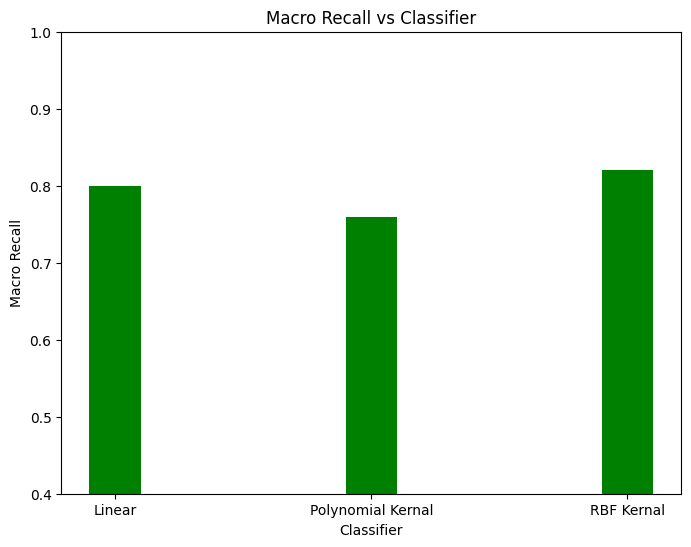

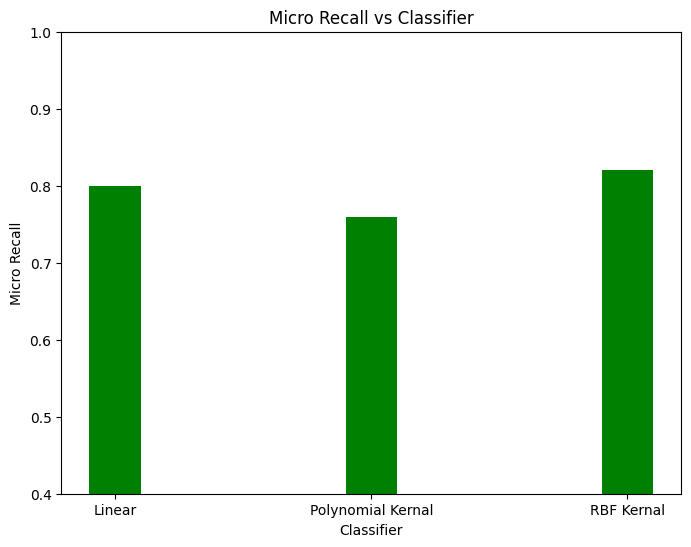

In [288]:
plot_evalution_metrices(Class, recall_per_class_l, 'Linear Kernal Recall  vs Class', 'Class', 'Recall')
plot_evalution_metrices(Class, recall_per_class_p, 'Poly Kernal Recall  vs Class', 'Class', 'Recall')
plot_evalution_metrices(Class, recall_per_class_rbf, 'RBF Kernal Recall  vs Class', 'Class', 'Recall')
plot_evalution_metrices(classifier, macro_recall, 'Macro Recall vs Classifier', 'Classifier','Macro Recall')
plot_evalution_metrices(classifier, micro_recall, 'Micro Recall vs Classifier', 'Classifier', 'Micro Recall')

In [289]:
classifier = ['Linear', 'Polynomial Kernal', 'RBF Kernal']
Class = ['Series M', 'Series L', 'Series N']
f1_per_class_l = f1_score(y_true, y_pred_l, average=None)
macro_f1_l = f1_score(y_true, y_pred_l, average='macro')
micro_f1_l = f1_score(y_true, y_pred_l, average='micro')

f1_per_class_p = f1_score(y_true, y_pred_p, average=None)
macro_f1_p = f1_score(y_true, y_pred_p, average='macro')
micro_f1_p = f1_score(y_true, y_pred_p, average='micro')

f1_per_class_rbf = f1_score(y_true, y_pred_rbf, average=None)
macro_f1_rbf = f1_score(y_true, y_pred_rbf, average='macro')
micro_f1_rbf = f1_score(y_true, y_pred_rbf, average='micro')

macro_f1 = [macro_f1_l, macro_f1_p, macro_f1_rbf]
micro_f1 = [micro_f1_l, micro_f1_p, micro_f1_rbf]

In [290]:
print("F1 Score per Class of Linear Kernal:", f1_per_class_l)
print("F1 Score per Class of Poly. Kernal: ", f1_per_class_p)
print("F1 Score per Class of RBF Kernal: ", f1_per_class_rbf)
print("Macro F1 Score of Classifier: ", macro_f1)
print("Micro F1 Score of Classifer: ", micro_f1)

F1 Score per Class of Linear Kernal: [0.98989899 0.7184466  0.69387755]
F1 Score per Class of Poly. Kernal:  [0.94736842 0.752      0.55      ]
F1 Score per Class of RBF Kernal:  [1.         0.73267327 0.72727273]
Macro F1 Score of Classifier:  [0.8007410476203819, 0.7497894736842105, 0.81998199819982]
Micro F1 Score of Classifer:  [0.8, 0.76, 0.82]


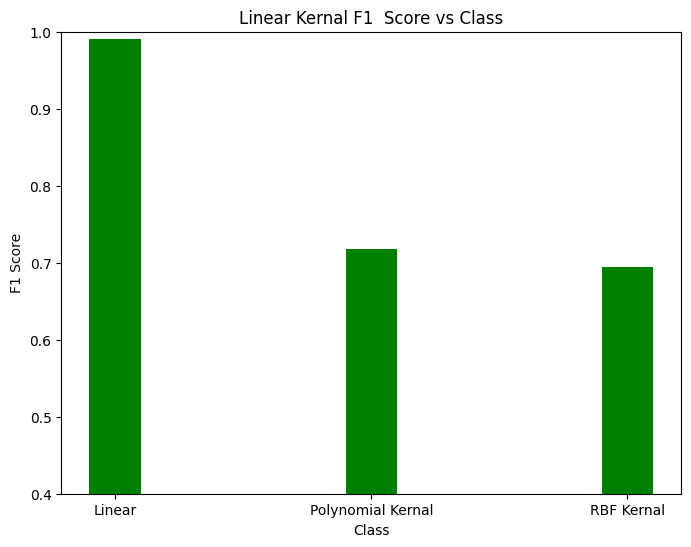

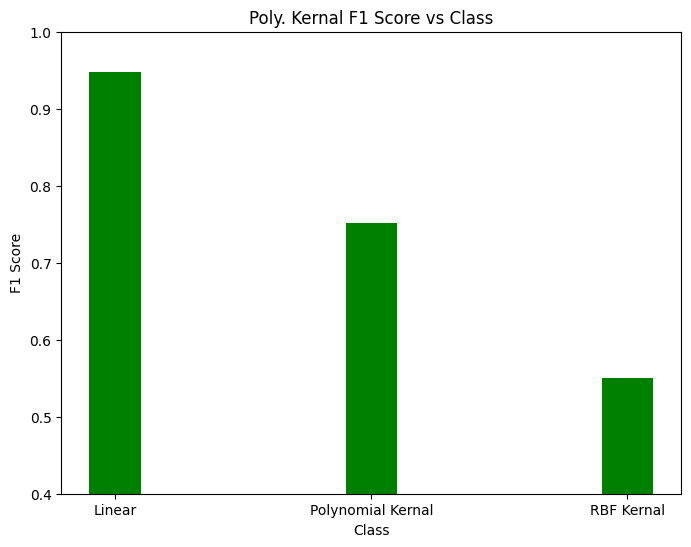

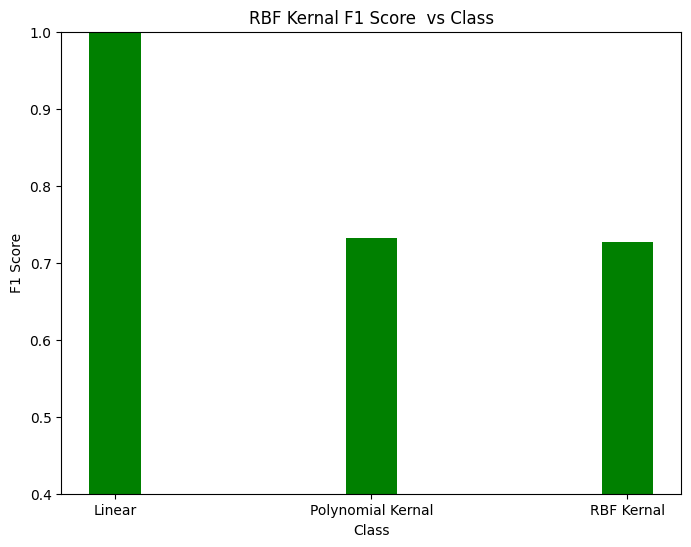

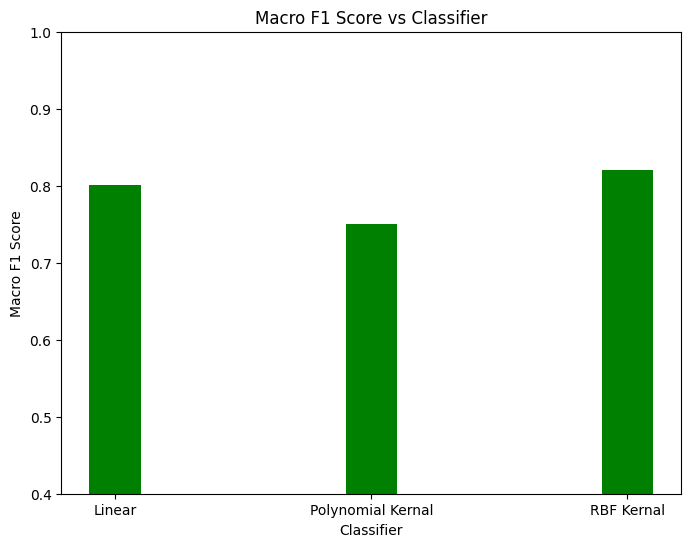

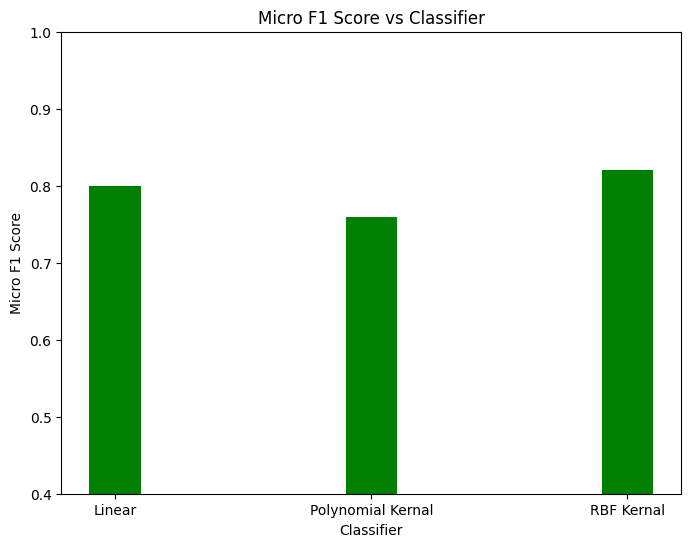

In [291]:
plot_evalution_metrices(classifier, f1_per_class_l, 'Linear Kernal F1  Score vs Class', 'Class', 'F1 Score')
plot_evalution_metrices(classifier, f1_per_class_p, 'Poly. Kernal F1 Score vs Class', 'Class', 'F1 Score')
plot_evalution_metrices(classifier, f1_per_class_rbf, 'RBF Kernal F1 Score  vs Class', 'Class', 'F1 Score')
plot_evalution_metrices(classifier, macro_f1, 'Macro F1 Score vs Classifier', 'Classifier','Macro F1 Score')
plot_evalution_metrices(classifier, micro_f1, 'Micro F1 Score vs Classifier', 'Classifier', 'Micro F1 Score')